In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils import mlp,train_test_model
from utils.scp_utils.scp import SCP
from utils.scp_utils.scp_v2 import SCP as SCP_v2
from utils.ewc_utils.onlineEWC import OnlineEWC
from utils.mas_utils.mas import MAS

from data.sequential_lines import Lines

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Get Configurations

In [2]:
n_samples=1000
epochs = 200
lr = 1e-3
batch_size = 100
input_size = 2
hidden_sizes = [128,64]
output_size = 2

num_task = 5
n_slices = 5

activation='ReLU'
slope=.1
device='cuda:0'

ewc_alpha=0.5
scp_alpha=0.5
mas_alpha=0.5

gain={
    'Sigmoid':1.,
    'TanH':1.,
    'ReLU':np.sqrt(2.),
    'leakyReLU':np.sqrt(2./(1.+slope**2))
}

In [3]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):        
        torch.nn.init.xavier_uniform_(m.weight,gain=gain[activation])
        if m.bias: 
            torch.nn.init.xavier_uniform_(m.bias,gain=gain[activation])

## Load Dataset

In [4]:
datagen = Lines(max_iter=num_task, num_samples=n_samples)
train_loader,test_loader=datagen.get_sequential_lines(n_task=num_task,batch_size=batch_size)

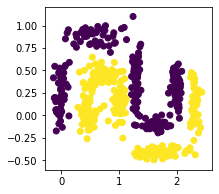

In [5]:
fig,ax =plt.subplots(1,1,figsize=(3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    sample,label=iter_data.next()
    ax.scatter(sample[:,0],sample[:,1],c=label)
# ax.set_xlim([-1.2,1.2])
# ax.set_ylim([-1.2,1.2])
plt.show()

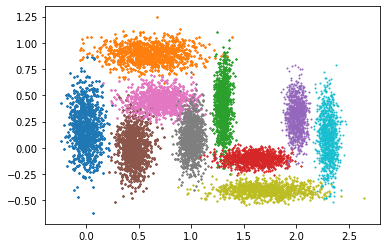

In [6]:
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
plt.figure()
for tid in range(num_task):
    for l in range(tid+1):
        idx = np.where(datagen.y == l)
        plt.scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        plt.scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)

In [9]:
X,Y=torch.meshgrid(torch.linspace(-0.5,2.5,150),torch.linspace(-0.75,1.25,100))
grid=torch.stack([X.reshape(-1),Y.reshape(-1)]).T

## Vanilla MLP

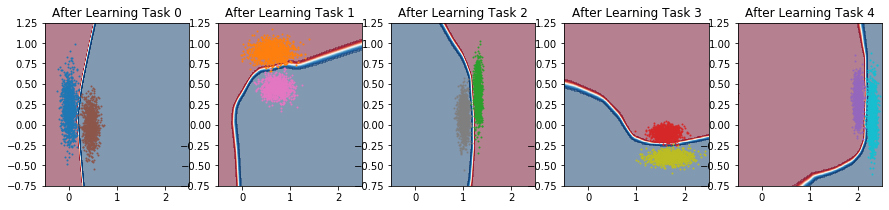

In [15]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## Perform training
loss, acc = {}, {}
for task in tqdm(range(num_task)):
    loss[task] = []
    acc[task] = []
    for _ in tqdm(range(epochs)):
        model.train()
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss[task].append(train_test_model.train_classifier(model=model,
                                                            optimizer=optimizer,
                                                            data_loader=train_loader[task],
                                                            device=device))            
        for sub_task in range(task + 1):
            acc[sub_task].append(train_test_model.test_classifier(model=model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            
        


Text(0.5, 0.98, 'Catastrophic forgetting')

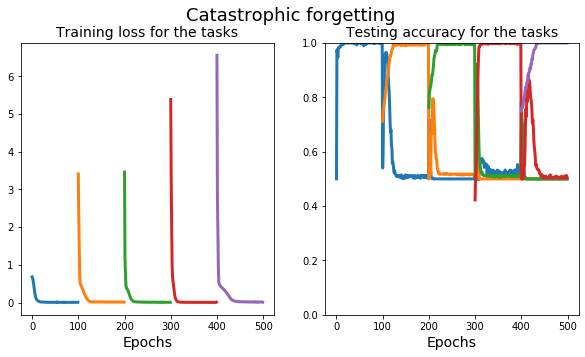

In [36]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the tasks',fontsize=14)
for t, v in acc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the tasks',fontsize=14)
fig.suptitle('Catastrophic forgetting',fontsize=18)

## Test EWC 

0.0


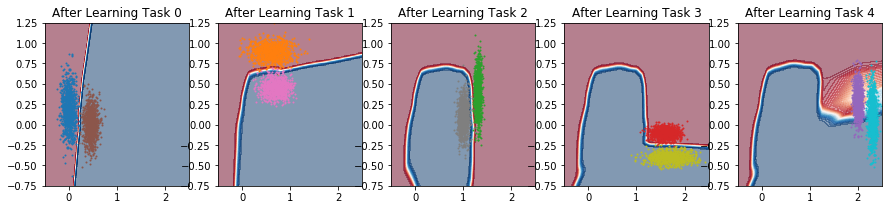

In [52]:
ewc_importance=1e+3

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
ewc= OnlineEWC(model,device=device,alpha=ewc_alpha)
average_importance=0
for i,n in enumerate(ewc._precision_matrices.keys()):
    average_importance+=ewc._precision_matrices[n].detach().cpu().numpy().mean()
average_importance/=i 
print(average_importance)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_ewc, acc_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_ewc[task] = []
    acc_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_ewc[sub_task].append(train_test_model.test_classifier(model=ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    ewc.consolidate(train_loader[task])    
    importance_EWC=list()
    for i,n in enumerate(ewc._precision_matrices.keys()):
        importance_EWC.append(ewc._precision_matrices[n].detach().cpu().numpy())
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using EWC Regularizer')

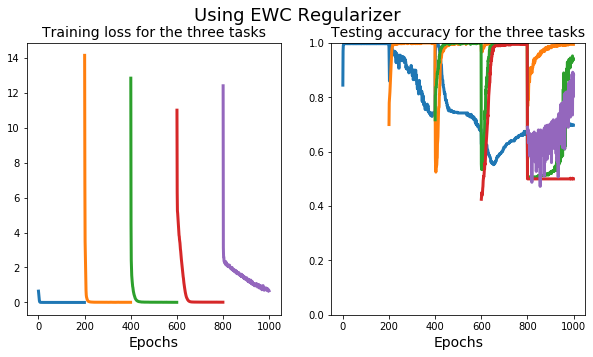

In [56]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using EWC Regularizer',fontsize=18)

## Test SketchEWC 

In [13]:
from utils.ewc_utils.sketchEWC import SketchEWC

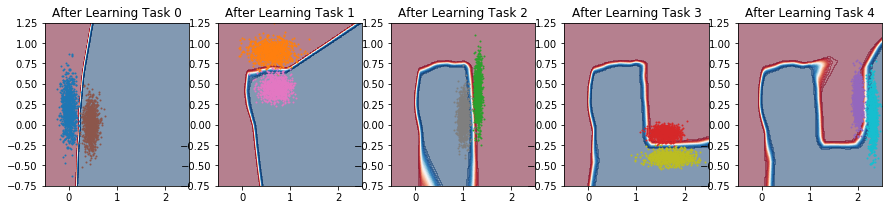

In [65]:
sketch_ewc_importance=1e4

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
sketch_ewc= SketchEWC(model,device=device,alpha=0.5,n_bucket=50)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_sketch_ewc, acc_sketch_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_sketch_ewc[task] = []
    acc_sketch_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_sketch_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=sketch_ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=sketch_ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_sketch_ewc[sub_task].append(train_test_model.test_classifier(model=sketch_ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device)) 
    sketch_ewc.consolidate(train_loader[task])    
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using SketchEWC Regularizer')

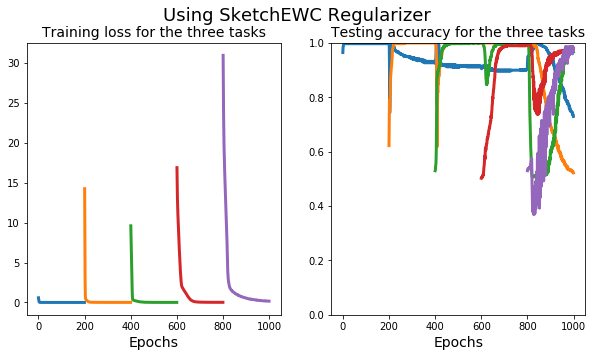

In [63]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_sketch_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_sketch_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SketchEWC Regularizer',fontsize=18)

## Full Hessian EWC (FIM)

In [7]:
from utils.ewc_utils.onlineEWC import FullEWC


20



20



20



20



20



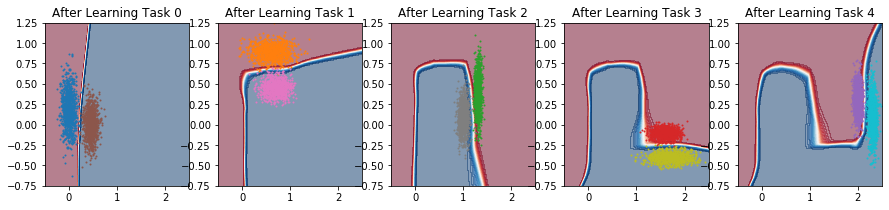

In [42]:
full_ewc_importance=1e+5

## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
# model.apply(weights_init)
full_ewc= FullEWC(model,device=device,alpha=ewc_alpha)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_full_ewc, acc_full_ewc = {}, {}
for task in tqdm(range(num_task)):
    loss_full_ewc[task] = []
    acc_full_ewc[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_full_ewc[task].append(train_test_model.onlineEWC_train_classifier(ewc=full_ewc,
                                                                      optimizer=optimizer,
                                                                      data_loader=train_loader[task],
                                                                      importance=full_ewc_importance,
                                                                      device=device))                           
        for sub_task in range(task + 1):
            acc_full_ewc[sub_task].append(train_test_model.test_classifier(model=full_ewc.model,
                                                                 data_loader=test_loader[sub_task],
                                                                 device=device))        
    full_ewc.consolidate(train_loader[task])
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using Full Hessian of EWC Regularizer (FIM)')

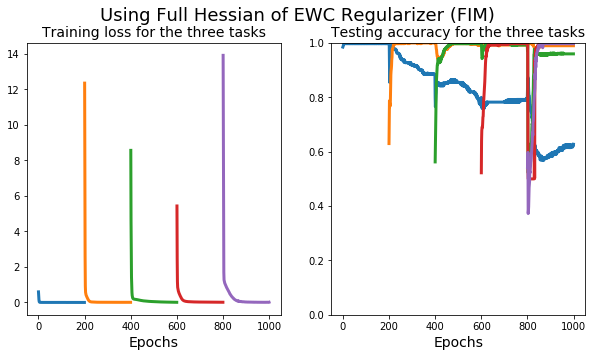

In [44]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_full_ewc.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_full_ewc.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using Full Hessian of EWC Regularizer (FIM)',fontsize=18)

## Testing MAS

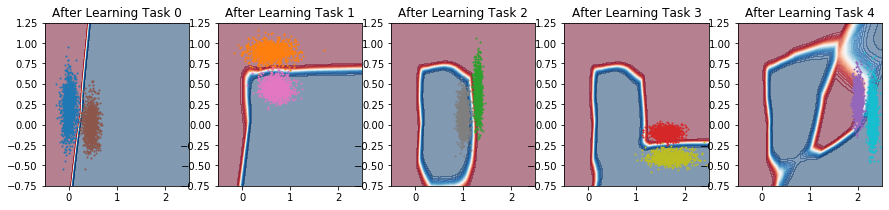

In [158]:
mas_importance=1e3
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)

mas= MAS(model,device=device,alpha=mas_alpha)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_mas, acc_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_mas[task] = []
    acc_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_mas[task].append(train_test_model.mas_train_classifier(mas=mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_mas[sub_task].append(train_test_model.test_classifier(model=mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    mas.consolidate(train_loader[task])
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


In [12]:
# for f in importance_MAS:
#     plt.hist(np.log10(f.reshape(-1)+1e-12),bins=100)
#     plt.show()

Text(0.5, 0.98, 'Using MAS Regularizer')

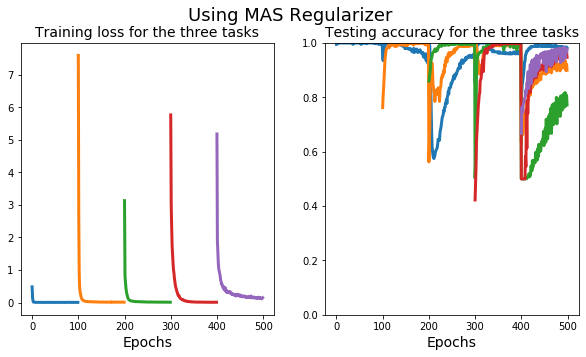

In [159]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using MAS Regularizer',fontsize=18)

## Testing SketchMAS

In [131]:
from utils.mas_utils.sketchMAS import SketchMAS

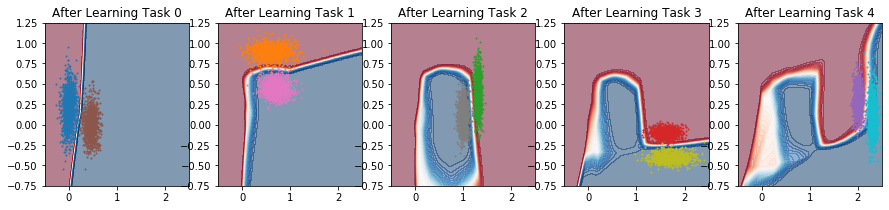

In [166]:
sketch_mas_importance=1e4
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)

sketch_mas= SketchMAS(model,device=device,alpha=0.5,n_bucket=50)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_sketch_mas, acc_sketch_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_sketch_mas[task] = []
    acc_sketch_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_sketch_mas[task].append(train_test_model.mas_train_classifier(mas=sketch_mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=sketch_mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_sketch_mas[sub_task].append(train_test_model.test_classifier(model=sketch_mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    sketch_mas.consolidate(train_loader[task])    
#     torch.save(mas.model.state_dict(), 'saved_models/model_mas_'+str(task)+'.pt') 
       
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using SketchMAS Regularizer')

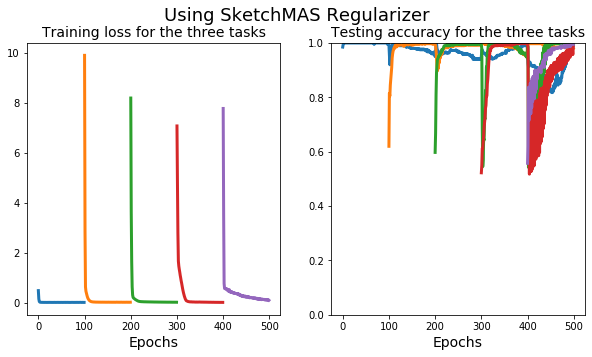

In [167]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_sketch_mas.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_sketch_mas.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SketchMAS Regularizer',fontsize=18)

## Full Hessian MAS

In [28]:
from utils.mas_utils.fullMAS import FullMAS

0it [00:00, ?it/s]

RuntimeError: grad can be implicitly created only for scalar outputs

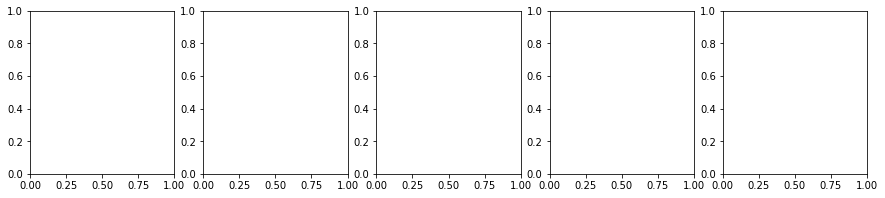

In [29]:
full_mas_importance=1e4
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)

full_mas= FullMAS(model,device=device,alpha=0.5)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_full_mas, acc_full_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_full_mas[task] = []
    acc_full_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_full_mas[task].append(train_test_model.mas_train_classifier(mas=full_mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=full_mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_full_mas[sub_task].append(train_test_model.test_classifier(model=full_mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    full_mas.consolidate(train_loader[task])    
#     torch.save(mas.model.state_dict(), 'saved_models/model_mas_'+str(task)+'.pt') 
       
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


## SCP

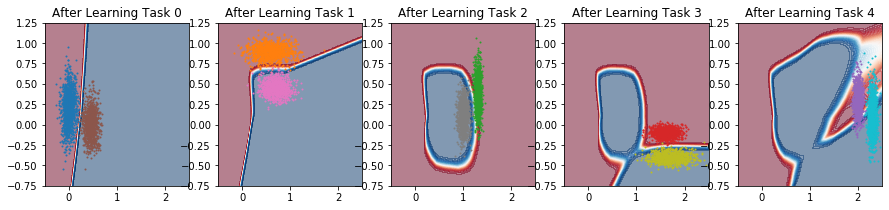

In [160]:
scp_importance=1e+3
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)
scp= SCP(model,device=device,alpha=scp_alpha,n_slices=n_slices)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_scp, acc_scp = {}, {}
for task in tqdm(range(num_task)):
    loss_scp[task] = []
    acc_scp[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_scp[task].append(train_test_model.scp_train_classifier(scp=scp,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=scp_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_scp[sub_task].append(train_test_model.test_classifier(model=scp.model,
                                                                     data_loader=test_loader[sub_task],
                                                                     device=device))            
    scp.consolidate(train_loader[task])    
#     torch.save(scp.model.state_dict(), 'saved_models/model_scp_'+str(task)+'.pt') 
    
    importance_SCP=list()
    for i,n in enumerate(scp._precision_matrices.keys()):
        importance_SCP.append(scp._precision_matrices[n].detach().cpu().numpy())
    
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


Text(0.5, 0.98, 'Using SCP Regularizer')

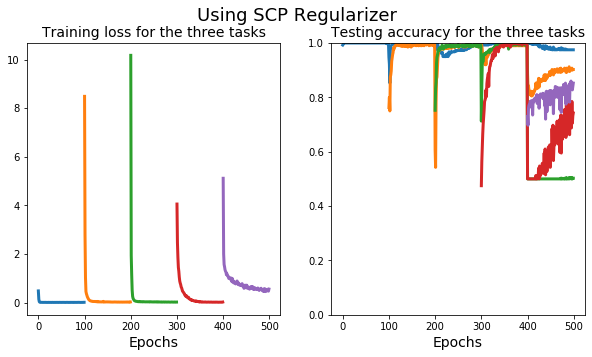

In [161]:
fig, ax=plt.subplots(1,2,figsize=(10,5))
for t, v in loss_scp.items():
    ax[0].plot(list(range(t * epochs, (t + 1) * epochs)), v,linewidth=3)
ax[0].set_xlabel('Epochs',fontsize=14)
ax[0].set_title('Training loss for the three tasks',fontsize=14)
for t, v in acc_scp.items():
    ax[1].plot(list(range(t * epochs, num_task * epochs)), v,linewidth=3)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs',fontsize=14)
ax[1].set_title('Testing accuracy for the three tasks',fontsize=14)
fig.suptitle('Using SCP Regularizer',fontsize=18)

## SketchSCP (Todo)

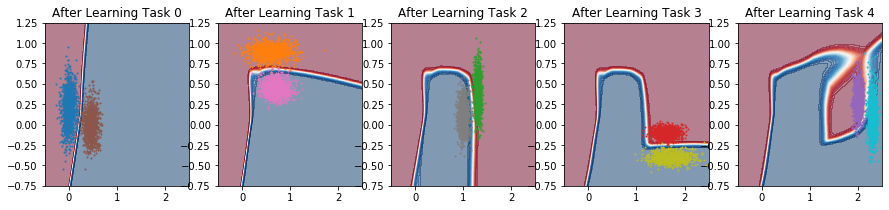

In [163]:
sketch_mas_importance=1e+5
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              require_bias=True,device=device).to(device)

sketch_mas= SketchMAS(model,device=device,alpha=0.5,n_bucket=50)

fig, ax=plt.subplots(1,num_task,figsize=(3*num_task,3))

## performing training
loss_sketch_mas, acc_sketch_mas = {}, {}
for task in tqdm(range(num_task)):
    loss_sketch_mas[task] = []
    acc_sketch_mas[task] = []
    for _ in tqdm(range(epochs)):
        optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)
        loss_sketch_mas[task].append(train_test_model.mas_train_classifier(mas=sketch_mas,
                                                                    optimizer=optimizer,
                                                                    data_loader=train_loader[task],
                                                                    importance=sketch_mas_importance,
                                                                    device=device))                           
        for sub_task in range(task + 1):
            acc_sketch_mas[sub_task].append(train_test_model.test_classifier(model=sketch_mas.model,
                                                                    data_loader=test_loader[sub_task],
                                                                     device=device))
    sketch_mas.consolidate(train_loader[task])    
#     torch.save(mas.model.state_dict(), 'saved_models/model_mas_'+str(task)+'.pt') 
       
    pred=nn.Softmax(-1)(model(grid.to(device)))[:,1].reshape(150,100).detach().cpu().numpy()
    ax[task].contourf(X, Y, pred,cmap='RdBu', alpha=0.5,levels=50)
    for l in range(task,task+1):
        idx = np.where(datagen.y == l)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l], s=1)
        idx = np.where(datagen.y == l+datagen.offset)
        ax[task].scatter(datagen.X[idx][:,0], datagen.X[idx][:,1], c=color[l+datagen.offset], s=1)
    ax[task].set_xlim(-0.5,2.5)
    ax[task].set_ylim(-0.75,1.25)
    ax[task].set_title('After Learning Task %d'%task)
plt.show()            


In [16]:
def get_mean_acc(acc,epochs):
    num_task=len(acc)
    temp=np.zeros((num_task,len(acc[0])))
    for t,v in acc.items():
        temp[t,range(t * epochs, num_task * epochs)]=v
        if t<num_task-1:
            temp[t+1,:]=temp[:t+1,:].mean(0)
    return temp.mean(0)

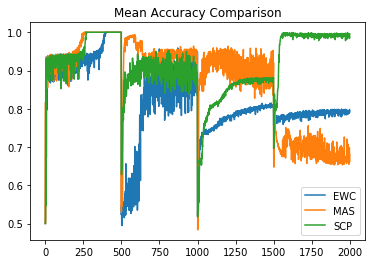

In [99]:
plt.plot(get_mean_acc(acc_ewc,epochs))
plt.plot(get_mean_acc(acc_mas,epochs))
plt.plot(get_mean_acc(acc_scp,epochs))
plt.title('Mean Accuracy Comparison')
plt.legend(['EWC','MAS','SCP'])